Non-negative Poisson Loss Reconstruction (APGM)
===============================================

This example demonstrates the use of class
[pgm.PGMStepSize](../_autosummary/scico.optimize.pgm.rst#scico.optimize.pgm.PGMStepSize)
to solve the non-negative reconstruction problem with Poisson negative
log likelihood loss

  $$\mathrm{argmin}_{\mathbf{x}} \; \frac{1}{2} \left( A(\mathbf{x}) -
  \mathbf{y} \log\left( A(\mathbf{x}) \right) + \log(\mathbf{y}!) \right) +
  \iota_{\mathrm{NN}}(\mathbf{x}_0) \;,$$

where $A$ is the forward operator, $\mathbf{y}$ is the measurement,
$\mathbf{x}$ is the signal reconstruction, and $\iota_{\mathrm{NN}}$ is
the indicator function of the non-negativity constraint.

This example also demonstrates the application of
[numpy.BlockArray](../_autosummary/scico.numpy.rst#scico.numpy.BlockArray),
[functional.SeparableFunctional](../_autosummary/scico.functional.rst#scico.functional.SeparableFunctional),
and
[functional.ZeroFunctional](../_autosummary/scico.functional.rst#scico.functional.ZeroFunctional)
to implement the forward operator
$A(\mathbf{x}) = A_0(\mathbf{x}_0) + A_1(\mathbf{x}_1)$
and the selective non-negativity constraint that only applies to
$\mathbf{x}_0$.

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import scico.numpy as snp
import scico.random
from scico import functional, loss, plot
from scico.numpy import BlockArray
from scico.operator import Operator
from scico.optimize.pgm import (
    AcceleratedPGM,
    AdaptiveBBStepSize,
    BBStepSize,
    LineSearchStepSize,
    RobustLineSearchStepSize,
)
from scico.typing import Shape
from scico.util import device_info
from scipy.linalg import dft
plot.config_notebook_plotting()

Construct a dictionary, a reference random reconstruction, and a test
measurement signal consisting of the synthesis of the reference
reconstruction.

In [2]:
m = 1024  # signal size
n = 8  # dictionary size
n0 = 2
n1 = n - n0

# Create dictionary with bump-like features.
D = ((snp.real(dft(m))[1 : n + 1, :m]) ** 12).T
D0 = D[:, :n0]
D1 = D[:, n0:]


# Define composed operator.
class ForwardOperator(Operator):
    """Toy problem non-linear forward operator with different treatment
       of x[0] and x[1].

    Attributes:
        D0: Matrix multiplying x[0].
        D1: Matrix multiplying x[1].
    """

    def __init__(self, input_shape: Shape, D0, D1, jit: bool = True):
        self.D0 = D0
        self.D1 = D1

        output_shape = (D0.shape[0],)

        super().__init__(
            input_shape=input_shape,
            input_dtype=snp.complex64,
            output_dtype=snp.complex64,
            output_shape=output_shape,
            jit=jit,
        )

    def _eval(self, x: BlockArray) -> BlockArray:
        return 10 * snp.exp(-D0 @ x[0]) + 5 * snp.exp(-D1 @ x[1])


x_gt, key = scico.random.uniform(((n0,), (n1,)), seed=12345)  # true coefficients

A = ForwardOperator(x_gt.shape, D0, D1)

lam = A(x_gt)
y, key = scico.random.poisson(lam, shape=lam.shape, key=key)  # synthetic signal

Set up the loss function and the regularization.

In [3]:
f = loss.PoissonLoss(y=y, A=A)

g0 = functional.NonNegativeIndicator()
g1 = functional.ZeroFunctional()
g = functional.SeparableFunctional([g0, g1])

Define common setup: maximum of iterations and initial estimate of solution.

In [4]:
maxiter = 50
x0, key = scico.random.uniform(((n0,), (n1,)), key=key)

Define plotting functionality.

In [5]:
def plot_results(hist, str_ss, L0, xsol, xgt, Aop):
    # Plot signal, coefficients and convergence statistics.
    fig = plot.figure(
        figsize=(12, 6),
        tight_layout=True,
    )
    gs = gridspec.GridSpec(nrows=2, ncols=3)

    fig.suptitle(
        "Results for PGM Solver and " + str_ss + r" ($L_0$: " + "{:4.2f}".format(L0) + ")",
        fontsize=14,
    )

    ax0 = fig.add_subplot(gs[0, 0])
    plot.plot(
        hist.Objective,
        ptyp="semilogy",
        title="Objective",
        xlbl="Iteration",
        fig=fig,
        ax=ax0,
    )

    ax1 = fig.add_subplot(gs[0, 1])
    plot.plot(
        hist.Residual,
        ptyp="semilogy",
        title="Residual",
        xlbl="Iteration",
        fig=fig,
        ax=ax1,
    )

    ax2 = fig.add_subplot(gs[0, 2])
    plot.plot(
        hist.L,
        ptyp="semilogy",
        title="L",
        xlbl="Iteration",
        fig=fig,
        ax=ax2,
    )

    ax3 = fig.add_subplot(gs[1, 0])
    plt.stem(snp.concatenate((xgt[0], xgt[1])), linefmt="C1-", markerfmt="C1o", basefmt="C1-")
    plt.stem(snp.concatenate((xsol[0], xsol[1])), linefmt="C2-", markerfmt="C2x", basefmt="C1-")
    plt.legend(["Ground Truth", "Recovered"])
    plt.xlabel("Index")
    plt.title("Coefficients")

    ax4 = fig.add_subplot(gs[1, 1:])
    plot.plot(
        snp.vstack((y, Aop(xgt), Aop(xsol))).T,
        title="Fit",
        xlbl="Index",
        lgnd=("y", "A(x_gt)", "A(x)"),
        fig=fig,
        ax=ax4,
    )
    fig.show()

Use default `PGMStepSize object`, set L0 based on norm of forward
operator and set up `AcceleratedPGM` solver object. Run the solver and
plot the recontructed signal and convergence statistics.

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Running solver with step size of class:  PGMStepSize
L0 (Specifically chosen so that convergence occurs):  1000.0 



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  8.76e-01  1.370e+03  1.000e+03  2.254e-01


  10  1.94e+00  1.338e+03  1.000e+03  1.171e-02


  20  2.35e+00  1.336e+03  1.000e+03  3.655e-03


  30  2.77e+00  1.336e+03  1.000e+03  9.183e-04


  40  3.18e+00  1.336e+03  1.000e+03  8.188e-04


  49  3.55e+00  1.336e+03  1.000e+03  4.336e-04


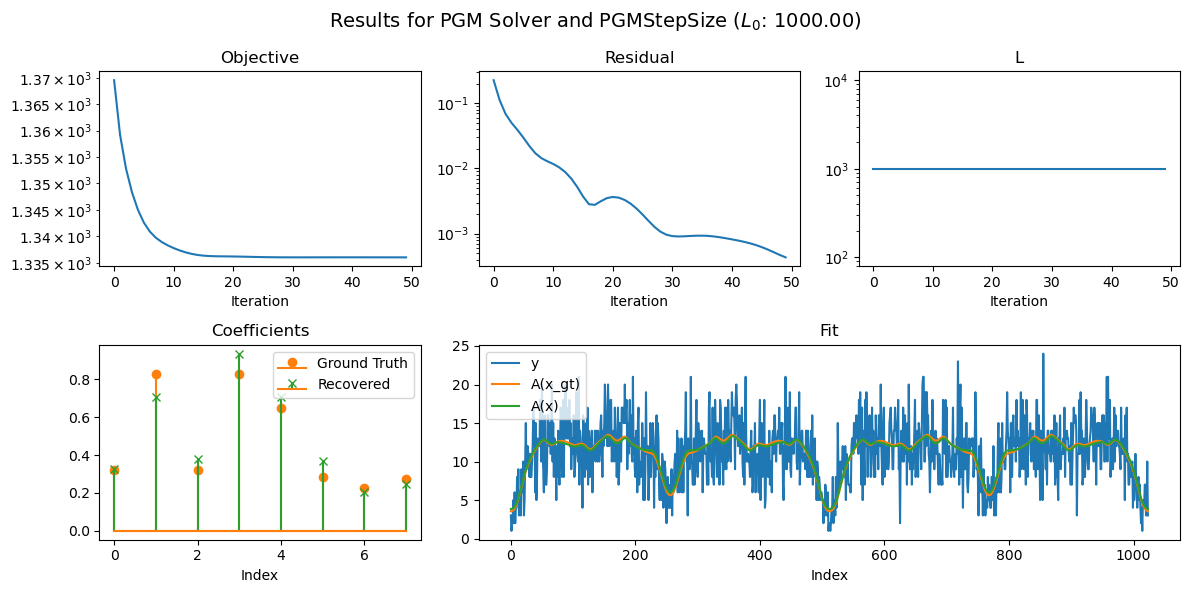

In [6]:
L0 = 1e3
str_L0 = "(Specifically chosen so that convergence occurs)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)
str_ss = type(solver.step_size).__name__

print(f"Solving on {device_info()}\n")
print("============================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # run the solver
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use `BBStepSize` object, set L0 with arbitary initial value and set up
`AcceleratedPGM` solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  BBStepSize
L0 (Arbitrary Initialization):  90.0 



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  7.42e-01  1.778e+03  9.000e+01  2.505e+00


  10  1.61e+00  1.337e+03  3.428e+02  2.665e-02


  20  2.07e+00  1.336e+03  3.729e+02  9.443e-03


  30  2.53e+00  1.336e+03  3.465e+02  3.014e-03


  40  2.99e+00  1.336e+03  3.797e+02  2.147e-03


  49  3.41e+00  1.336e+03  3.608e+02  1.370e-03


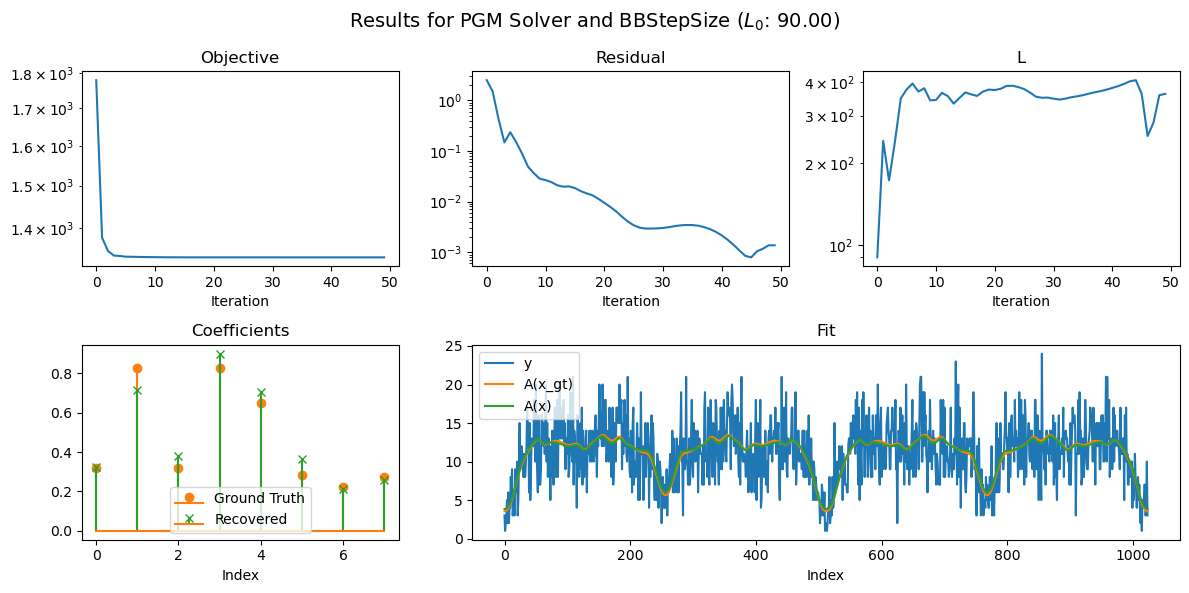

In [7]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=BBStepSize(),
)
str_ss = type(solver.step_size).__name__

print("===================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # run the solver
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use `AdaptiveBBStepSize` object, set L0 with arbitary initial value and
set up `AcceleratedPGM` solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  AdaptiveBBStepSize
L0 (Arbitrary Initialization):  90.0 

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  9.68e-03  1.778e+03  9.000e+01  2.505e+00


  10  5.58e-01  1.337e+03  3.015e+02  7.647e-02


  20  1.05e+00  1.336e+03  3.758e+02  8.122e-03


  30  1.52e+00  1.336e+03  3.551e+02  4.430e-03


  40  2.00e+00  1.336e+03  3.963e+02  1.687e-03


  49  2.46e+00  1.336e+03  3.491e+02  2.896e-03


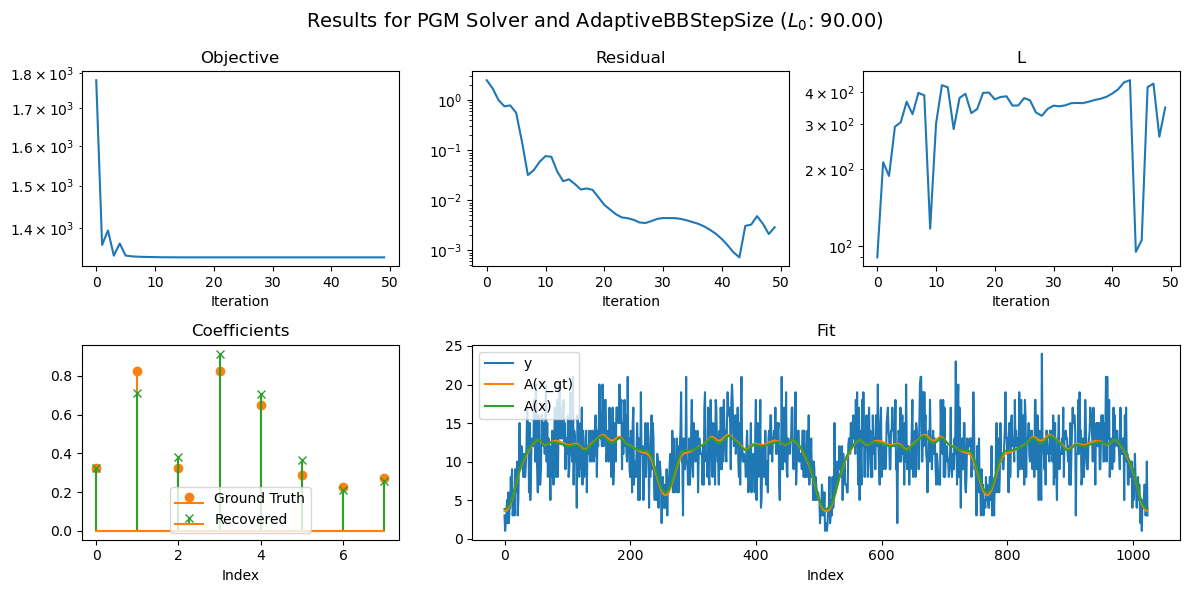

In [8]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=AdaptiveBBStepSize(kappa=0.75),
)
str_ss = type(solver.step_size).__name__

print("===========================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # run the solver
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use `LineSearchStepSize` object, set L0 with arbitary initial value and
set up `AcceleratedPGM` solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  LineSearchStepSize
L0 (Arbitrary Initialization):  90.0 



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  2.75e-01  1.358e+03  5.573e+02  4.045e-01


  10  8.03e-01  1.336e+03  5.573e+02  8.138e-03


  20  1.34e+00  1.336e+03  5.573e+02  1.742e-03


  30  1.88e+00  1.336e+03  5.573e+02  1.191e-03


  40  2.41e+00  1.336e+03  5.573e+02  4.848e-04


  49  2.89e+00  1.336e+03  5.573e+02  3.049e-04


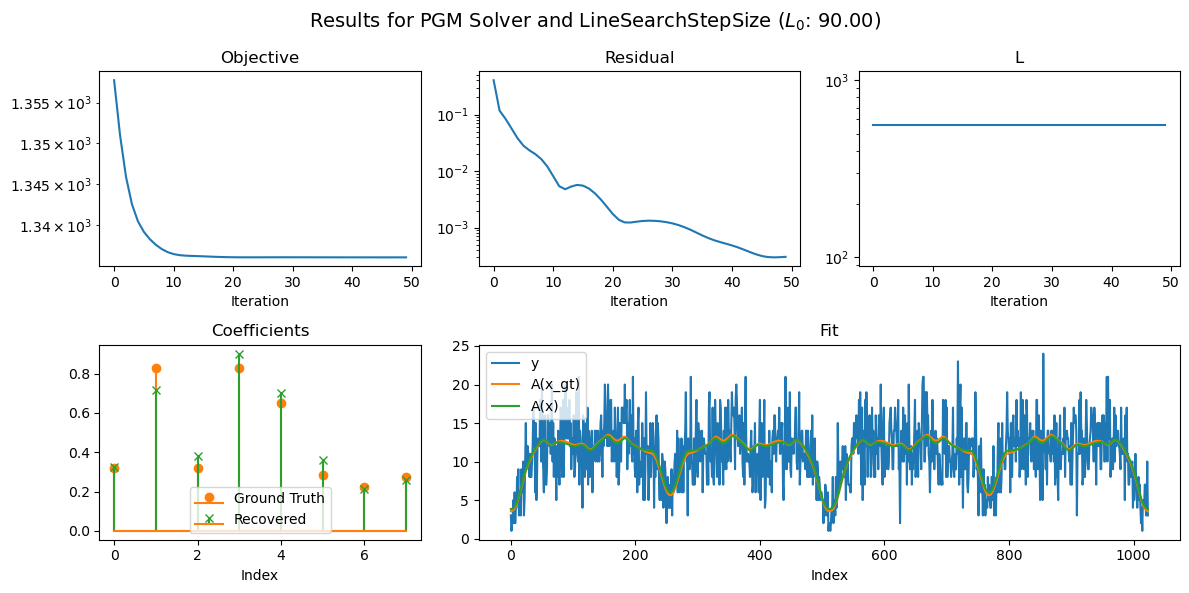

In [9]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=LineSearchStepSize(),
)
str_ss = type(solver.step_size).__name__

print("===========================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # run the solver
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use `RobustLineSearchStepSize` object, set L0 with arbitary initial
value and set up `AcceleratedPGM` solver object. Run the solver and
plot the recontructed signal and convergence statistics.

Running solver with step size of class:  RobustLineSearchStepSize
L0 (Arbitrary Initialization):  90.0 

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  1.60e-01  1.360e+03  6.480e+02  3.479e-01


  10  6.27e-01  1.336e+03  2.259e+02  4.968e-02


  20  1.12e+00  1.336e+03  3.151e+02  8.222e-03


  30  1.62e+00  1.336e+03  4.395e+02  3.535e-03


  40  2.13e+00  1.336e+03  1.226e+03  1.399e-03


  49  2.56e+00  1.336e+03  4.750e+02  9.125e-04


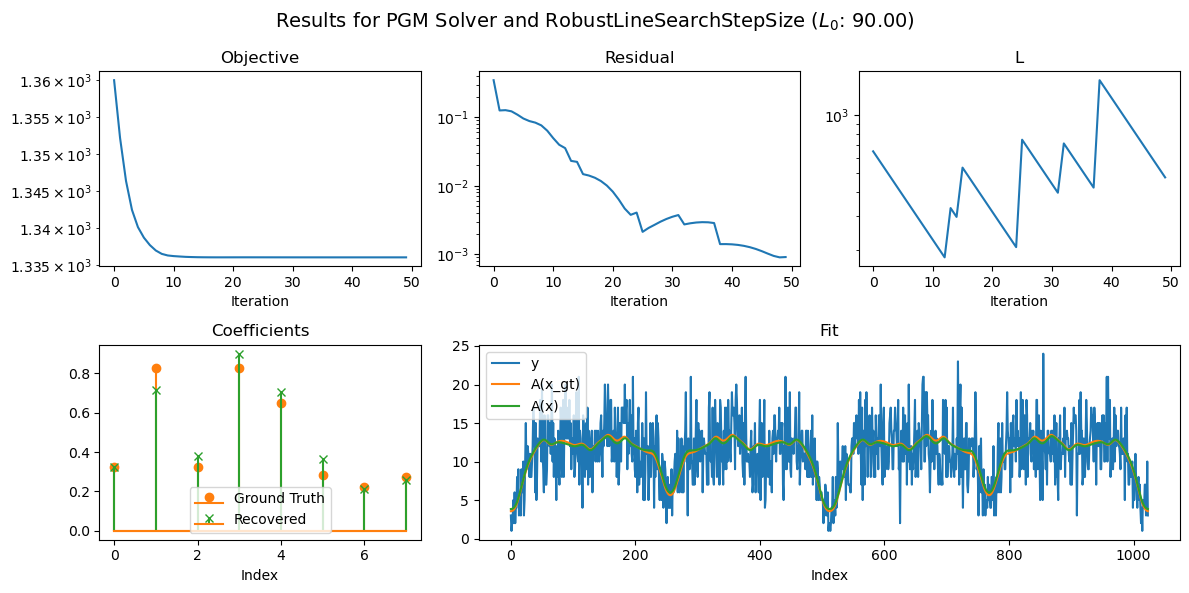

In [10]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=RobustLineSearchStepSize(),
)
str_ss = type(solver.step_size).__name__

print("=================================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # run the solver
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)